<a href="https://colab.research.google.com/github/DeepikaNC/Diabeties-app/blob/main/Diabeties_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Diabetes Prediction

 [dataset](https://https://www.kaggle.com/datasets/gzdekzlkaya/pima-indians-diabetes-dataset)

 This project explores a diabetes dataset to develop a predictive model that can assess the likelihood of a women having diabetes based on various medical features.

 ***Features***

Pregnancies: Number of times pregnant

Glucose: Plasma glucose concentration

BloodPressure: Diastolic blood pressure (mm Hg)

SkinThickness: Triceps skinfold thickness (mm)

Insulin: 2-Hour serum insulin (mu U/ml)

BMI: Body mass index

DiabetesPedigreeFunction: Diabetes likelihood based on family history

Age: Age in years

Outcome: Diabetes diagnosis result (1 = positive, 0 = negative)

**Importing all the necessary libraries and methods**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, confusion_matrix,ConfusionMatrixDisplay
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, recall_score,f1_score,balanced_accuracy_score,precision_score


In [ ]:
df = pd.read_csv("pima_diabetes_data.csv")
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [ ]:
df.shape

(768, 9)

# **Cleaning the data**

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [ ]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


**1.Handling outliers in the pregnancies column**

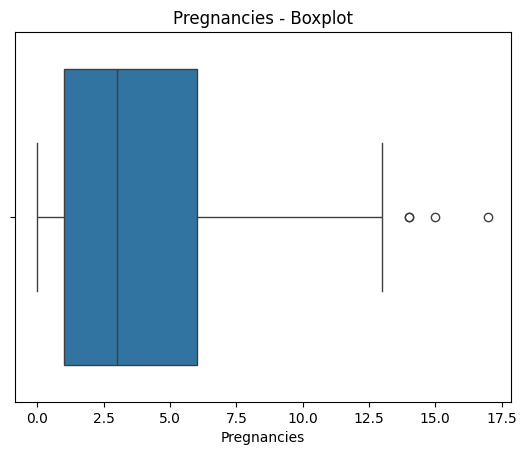

In [ ]:
sns.boxplot(x=df['Pregnancies'])
plt.title('Pregnancies - Boxplot')
plt.show()

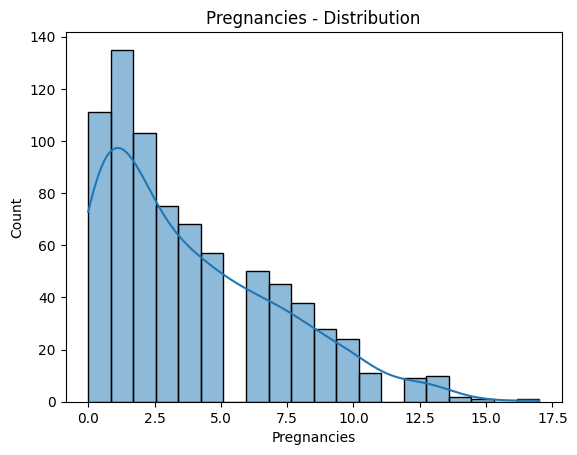

In [ ]:
sns.histplot(df['Pregnancies'], bins=20, kde=True)
plt.title('Pregnancies - Distribution')
plt.show()

There are outliers which are possible but may mislead the model ,so they are capped to reduce its impact.

In [ ]:
df['Pregnancies'] = df['Pregnancies'].apply(lambda x: 12 if x > 12 else x)

**2. Handled invalid Glucose values:**

In [ ]:
int((df['Glucose'] == 0).sum())

5

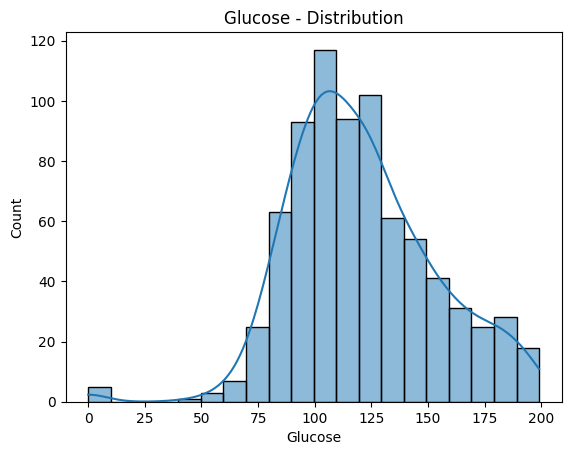

In [ ]:
sns.histplot(df['Glucose'], bins=20, kde=True)
plt.title('Glucose - Distribution')
plt.show()

In [ ]:

q1_glucose = df['Glucose'].quantile(0.25)
print("25th percentile (Q1) of Glucose:", q1_glucose)


25th percentile (Q1) of Glucose: 99.0



Replaced glucose values <30 (physiologically impossible) with the median of valid (≥30) values to maintain data quality.

In [ ]:
valid_glucose = df.loc[df['Glucose'] >= 30, 'Glucose']
median_glucose = valid_glucose.median()
df.loc[df['Glucose'] < 30, 'Glucose'] = median_glucose

**3. Handled invalid Blood pressure:**

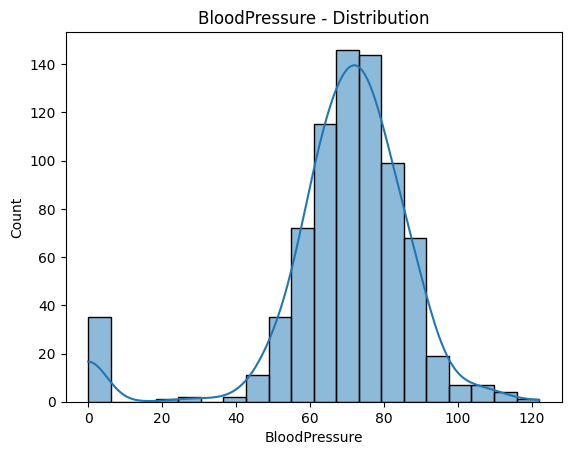

In [ ]:
sns.histplot(df['BloodPressure'], bins=20, kde=True)
plt.title('BloodPressure - Distribution')
plt.show()

In [ ]:
valid_bp = df.loc[df['BloodPressure'] >= 30, 'BloodPressure']
median_bp = valid_bp.median()
df.loc[df['BloodPressure'] < 30, 'BloodPressure'] = median_bp


**4. Capped SkinThickness outliers:**

In [ ]:
skin_thickness_less_than_3_count = int((df['SkinThickness'] < 3).sum())
print(f"Count of datapoints with SkinThickness less than 3: {skin_thickness_less_than_3_count}")

Count of datapoints with SkinThickness less than 3: 227


In [ ]:
# check  how many  people with skin thickness  less than 3 are diabetic

diabetic_skin_thickness_less_than_3 = df[(df['SkinThickness'] < 3) & (df['Outcome'] == 1)]
num_diabetic_skin_thickness_less_than_3 = len(diabetic_skin_thickness_less_than_3)

print(f"Number of people with SkinThickness less than 3 who are diabetic: {num_diabetic_skin_thickness_less_than_3}")

Number of people with SkinThickness less than 3 who are diabetic: 88


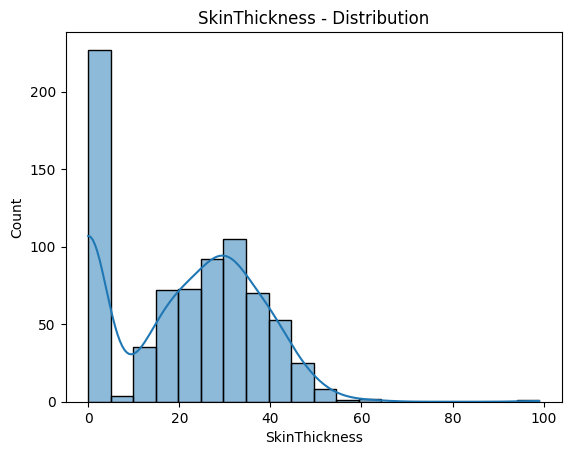

In [ ]:
sns.histplot(df['SkinThickness'], bins=20, kde=True)
plt.title('SkinThickness - Distribution')
plt.show()

In [ ]:
df["SkinThickness"] = df["SkinThickness"].apply(lambda x: 3 if x < 3 else x)
df["SkinThickness"] = df["SkinThickness"].apply(lambda x: 50 if x > 50 else x)


**5. Cleaned Insulin:**

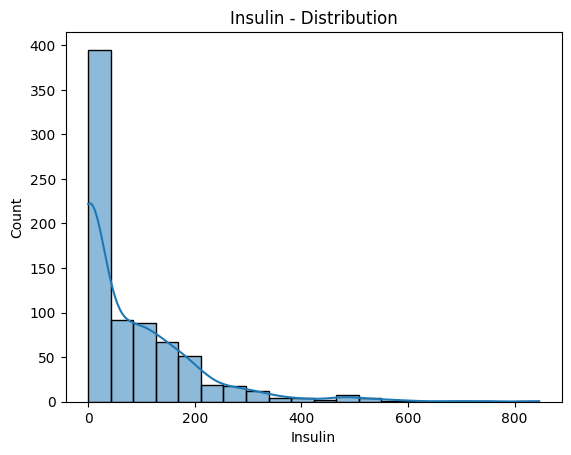

In [ ]:
sns.histplot(df['Insulin'], bins=20, kde=True)
plt.title('Insulin - Distribution')
plt.show()

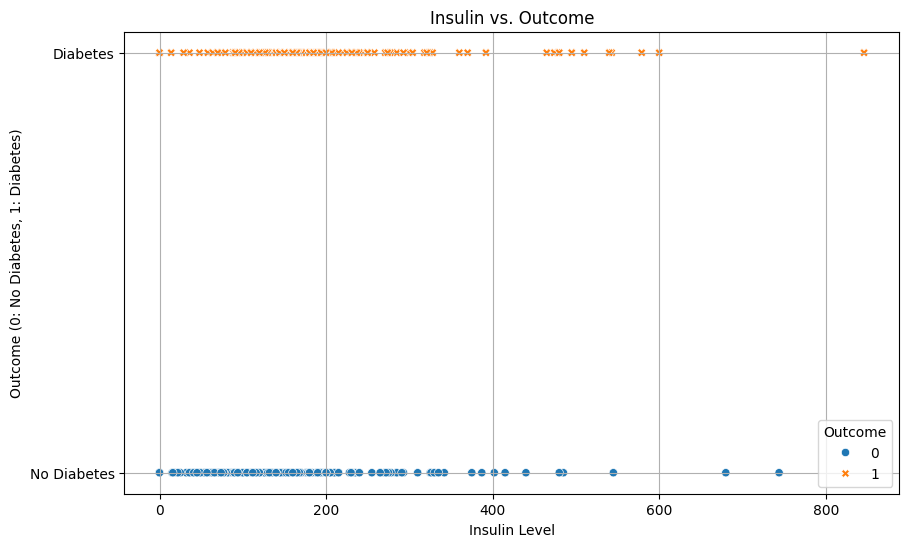

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='Insulin', y='Outcome', hue='Outcome', style='Outcome')
plt.title('Insulin vs. Outcome')
plt.xlabel('Insulin Level')
plt.ylabel('Outcome (0: No Diabetes, 1: Diabetes)')
plt.yticks([0, 1], ['No Diabetes', 'Diabetes'])
plt.grid(True)
plt.show()


In [ ]:
non_zero_insulin = df[df['Insulin'] != 0]['Insulin']
Q1 = non_zero_insulin.quantile(0.25)
Q3 = non_zero_insulin.quantile(0.75)
IQR = Q3 - Q1
lower = max(Q1 - 1.5 * IQR, 0)  # Lower bound can't be negative
upper = Q3 + 1.5 * IQR

print(f"Lower bound for Insulin: {lower}")
print(f"Upper bound for Insulin: {upper}")




Lower bound for Insulin: 0
Upper bound for Insulin: 360.625


Replaced 0 with median of valid values and capped values above 360.

In [ ]:
median_insulin = df[df['Insulin'] != 0]['Insulin'].median()
df['Insulin'] = df['Insulin'].replace(0, median_insulin)
df.loc[df['Insulin'] > 360, 'Insulin'] = 360

**6. Cleaned BMI:**


In [ ]:
df[df['BMI']<10]

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
9,8,125,96,3,125,0.0,0.232,54,1
49,7,105,72,3,125,0.0,0.305,24,0
60,2,84,72,3,125,0.0,0.304,21,0
81,2,74,72,3,125,0.0,0.102,22,0
145,0,102,75,23,125,0.0,0.572,21,0
371,0,118,64,23,89,0.0,1.731,21,0
426,0,94,72,3,125,0.0,0.256,25,0
494,3,80,72,3,125,0.0,0.174,22,0
522,6,114,72,3,125,0.0,0.189,26,0
684,5,136,82,3,125,0.0,0.640,69,0


Replaced BMI <10 with median of valid values and capped values above 60.

In [ ]:
median_bmi = df[df['BMI'] >= 10]['BMI'].median()
df.loc[df['BMI'] < 10, 'BMI'] = median_bmi
df.loc[df['BMI'] > 60, 'BMI'] = 60

In [ ]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.816406,121.656250,72.449219,21.304688,136.010417,32.445964,0.471876,33.240885,0.348958
std,3.289015,30.438286,11.969650,14.474304,65.493691,6.833176,0.331329,11.760232,0.476951
min,0.000000,44.000000,30.000000,3.000000,14.000000,18.200000,0.078000,21.000000,0.000000
25%,1.000000,99.750000,64.000000,3.000000,121.500000,27.500000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,125.000000,32.300000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,12.000000,199.000000,122.000000,50.000000,360.000000,60.000000,2.420000,81.000000,1.000000


# Handled class imbalance:
Used stratified sampling to maintain Outcome distribution during train-test split.

In [ ]:
print(df['Outcome'].value_counts(normalize=True) * 100)


Outcome
0    65.104167
1    34.895833
Name: proportion, dtype: float64


# Model Training and Testing

In [ ]:
x=df.drop(columns="Outcome")
y=df["Outcome"]

In [ ]:

X_train, X_test, y_train, y_test = train_test_split(x, y,
                                                    test_size=0.2,
                                                    stratify=y,
                                                    random_state=42)


Scaled features and applied SMOTE to balance training data for smoother model testing.

In [ ]:

scale_features = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction']
scaler = StandardScaler()
X_train[scale_features] = scaler.fit_transform(X_train[scale_features])
X_test[scale_features] = scaler.transform(X_test[scale_features])

smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train,y_train)



**1. LOGISTIC REGRESSION**

In [ ]:
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train_res, y_train_res)
log_pred = logreg.predict(X_test)

In [ ]:
cr=classification_report(y_test, log_pred)
print(cr)

              precision    recall  f1-score   support

           0       0.83      0.74      0.78       100
           1       0.60      0.72      0.66        54

    accuracy                           0.73       154
   macro avg       0.72      0.73      0.72       154
weighted avg       0.75      0.73      0.74       154



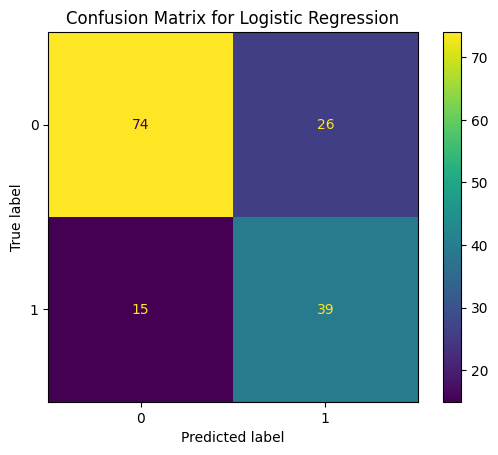

In [ ]:
cm=confusion_matrix(y_test, log_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot()
plt.title("Confusion Matrix for Logistic Regression")

plt.show()

**2. SUPPORT VECTOR CLASSIFICATION**

In [ ]:
svm= SVC()
svm.fit(X_train_res, y_train_res)
svm_pred = svm.predict(X_test)

In [ ]:
cr=classification_report(y_test, svm_pred)
print(cr)

              precision    recall  f1-score   support

           0       0.87      0.71      0.78       100
           1       0.60      0.80      0.68        54

    accuracy                           0.74       154
   macro avg       0.73      0.75      0.73       154
weighted avg       0.77      0.74      0.75       154



**3. K NEAREST NEIGHBOUR**

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_res, y_train_res)
knn_pred = knn.predict(X_test)

In [ ]:
cr=classification_report(y_test,knn_pred)
print(cr)

              precision    recall  f1-score   support

           0       0.81      0.70      0.75       100
           1       0.56      0.70      0.62        54

    accuracy                           0.70       154
   macro avg       0.69      0.70      0.69       154
weighted avg       0.72      0.70      0.71       154



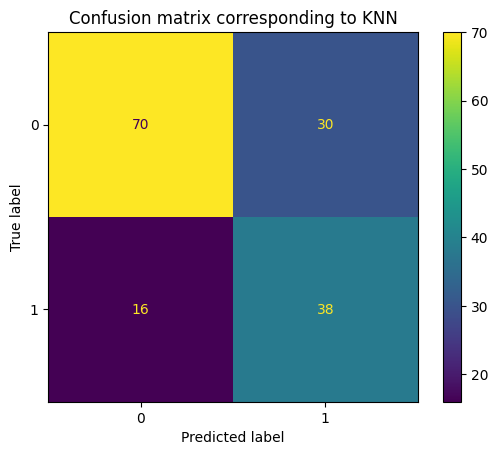

In [ ]:
cm = confusion_matrix(y_test, knn_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot()
plt.title("Confusion matrix corresponding to KNN")
plt.show()

**4.RANDOM FOREST**

In [ ]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_res, y_train_res)
rf_pred = rf.predict(X_test)

In [ ]:
cr=classification_report(y_test,rf_pred)
print(cr)

              precision    recall  f1-score   support

           0       0.82      0.74      0.78       100
           1       0.59      0.70      0.64        54

    accuracy                           0.73       154
   macro avg       0.71      0.72      0.71       154
weighted avg       0.74      0.73      0.73       154



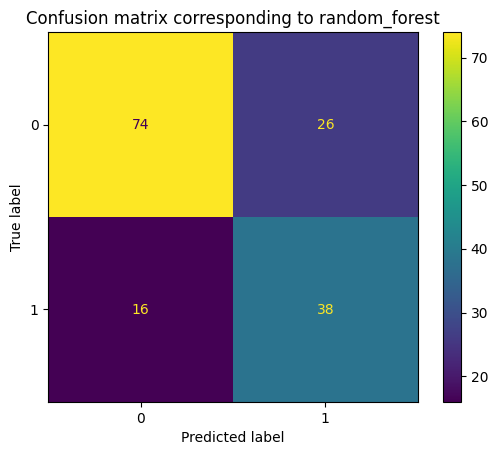

In [ ]:
cm = confusion_matrix(y_test, rf_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot()
plt.title("Confusion matrix corresponding to random_forest")
plt.show()

5. XGBOOST CLASSIFIER

In [ ]:
from xgboost import XGBClassifier
xg_boost = XGBClassifier( eval_metric='logloss', random_state=42)
xg_boost.fit(X_train_res, y_train_res)
xg_pred = xg_boost.predict(X_test)


In [ ]:
cr=classification_report(y_test,xg_pred)
print(cr)

              precision    recall  f1-score   support

           0       0.83      0.80      0.82       100
           1       0.66      0.70      0.68        54

    accuracy                           0.77       154
   macro avg       0.74      0.75      0.75       154
weighted avg       0.77      0.77      0.77       154



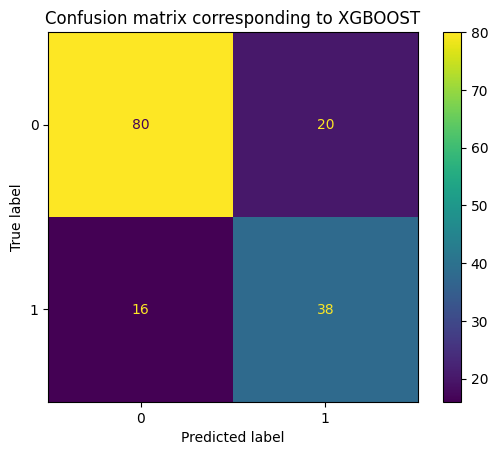

In [ ]:
cm = confusion_matrix(y_test, xg_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot()
plt.title("Confusion matrix corresponding to XGBOOST")
plt.show()

**Model testing:**
Tried multiple models with various parameters — XGBoost and Random Forest gave the best results.

In [ ]:


models_and_params = {
    'logreg': {
        'model': LogisticRegression(solver='liblinear'),
        'params': {
            'model__C': [0.01, 0.1, 1, 10],
            'model__penalty': ['l1', 'l2']
        }
    },
    'svm': {
        'model': SVC(probability=True),
        'params': {
            'model__C': [0.1, 1, 10],
            'model__kernel': ['linear', 'rbf'],
            'model__gamma': ['scale', 'auto']
        }
    },
    'rf': {
        'model': RandomForestClassifier(),
        'params': {
            'model__n_estimators': [50, 100],
            'model__max_depth': [None, 5, 10],
            'model__min_samples_split': [2, 5]
        }
    },
    'xgb': {
        'model': XGBClassifier(eval_metric='logloss'),
        'params': {
            'model__n_estimators': [50, 100],
            'model__max_depth': [3, 5, 7],
            'model__learning_rate': [0.01, 0.1, 0.2],
            'model__subsample': [0.8, 1.0]
        }
    }
}


# Hyperparamter tuning

For XGBoost classifier

In [ ]:

pipe = ImbPipeline([
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=42,k_neighbors=3)),
    ('model', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42))
])

params = {
    'model__n_estimators': [50, 100, 200],
    'model__max_depth': [3, 5, 7],
    'model__learning_rate': [0.01, 0.1, 0.2],
    'model__subsample': [0.8, 1.0]
}

For Random forest model

In [ ]:
#random forest after smote (currently best model)
pipe = ImbPipeline([
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=42,k_neighbors=3)),
    ('model', RandomForestClassifier(random_state=42,class_weight='balanced'))
])

params = {
    'model__n_estimators': [100, 200],
    'model__max_depth': [5, 10, None],
    'model__min_samples_split': [2, 5],
}

In [ ]:
from sklearn.model_selection import GridSearchCV

grid = GridSearchCV(pipe, params, cv=5, scoring='accuracy', n_jobs=-1)
grid.fit(X_train, y_train)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('smote',
                                        SMOTE(k_neighbors=3, random_state=42)),
                                       ('model',
                                        RandomForestClassifier(class_weight='balanced',
                                                               random_state=42))]),
             n_jobs=-1,
             param_grid={'model__max_depth': [5, 10, None],
                         'model__min_samples_split': [2, 5],
                         'model__n_estimators': [100, 200]},
             scoring='accuracy')

In [ ]:
 best_model = grid.best_estimator_
 y_probs = best_model.predict_proba(X_test)[:, 1]

# Threshold tuning (focused around 0.4–0.6)

thresholds = np.arange(0.4, 0.61, 0.01)
best_threshold = 0.5
best_bal_acc = 0

for t in thresholds:
    y_pred_thresh = (y_probs >= t).astype(int)
    bal_acc = balanced_accuracy_score(y_test, y_pred_thresh)
    if bal_acc > best_bal_acc:
        best_bal_acc = bal_acc
        best_threshold = t

# Final prediction with best threshold
y_pred_final = (y_probs >= best_threshold).astype(int)

In [ ]:
print(classification_report(y_test, y_pred_final))



              precision    recall  f1-score   support

           0       0.86      0.76      0.81       100
           1       0.64      0.78      0.70        54

    accuracy                           0.77       154
   macro avg       0.75      0.77      0.75       154
weighted avg       0.78      0.77      0.77       154



In [ ]:
best_params_= grid.best_params_
print(best_params_)
print(best_threshold)

{'model__max_depth': 5, 'model__min_samples_split': 5, 'model__n_estimators': 200}
0.5400000000000001


In [ ]:
accuracy = accuracy_score(y_test, y_pred_final)
precision = precision_score(y_test, y_pred_final, average='binary')
recall = recall_score(y_test, y_pred_final, average='binary')
f1 = f1_score(y_test, y_pred_final, average='binary')
b_a=balanced_accuracy_score(y_test, y_pred_final)
print(f"Balanced accuracy:{b_a:.2f}")

print(f"Accuracy:  {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall:    {recall:.2f}")
print(f"F1 Score:  {f1:.2f}")


Balanced accuracy:0.77
Accuracy:  0.77
Precision: 0.64
Recall:    0.78
F1 Score:  0.70
